In [1]:
candidate = "[1*]C(=O)C[4*].[4*]CC(O)COC(=O)CCCCCN[5*]|[4*]-[*:1].[5*]-[*:2]>>[$([C&!D1&!$(C=*)]-&!@[#6]):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2] |0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5"

In [2]:
def parse_parts(value: str):
    split_values = value.split("|")
    smiles_part = split_values[0]
    smarts_part = split_values[1]
    weight_part = "|" + "|".join(split_values[2:])
    return smiles_part, smarts_part, weight_part

In [3]:
smiles_part, smarts_part, weight_part = parse_parts(candidate)

In [4]:
smiles_part 

'[1*]C(=O)C[4*].[4*]CC(O)COC(=O)CCCCCN[5*]'

In [5]:
from rdkit import Chem
import copy

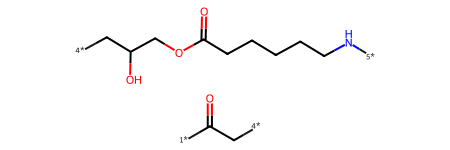

In [6]:
Chem.MolFromSmiles(smiles_part)

In [7]:
def show_mol(mol, size=(2000, 500)):
    from rdkit.Chem import Draw
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.ipython_useSVG = True
    return Draw.MolToImage(mol, size=size)

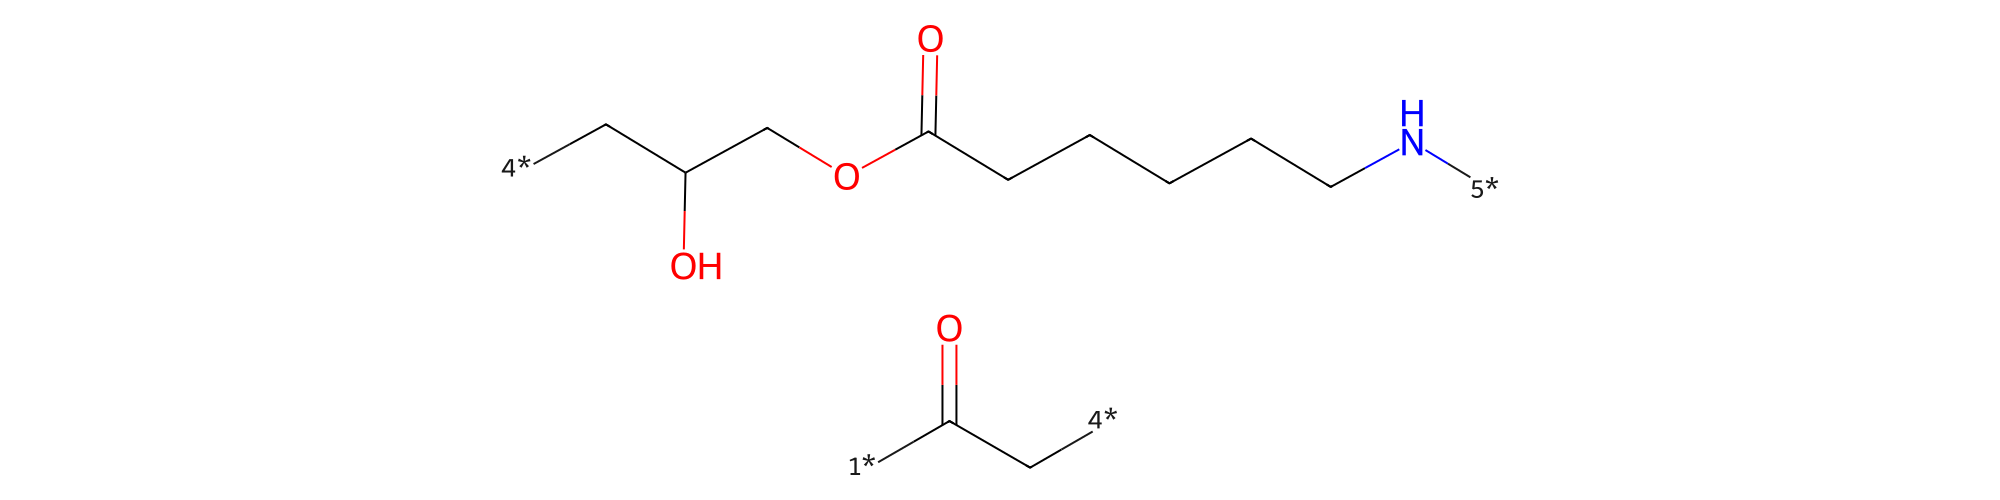

In [8]:
show_mol(Chem.MolFromSmiles(smiles_part))

In [9]:
rw_mol = Chem.RWMol(Chem.MolFromSmiles(smiles_part))

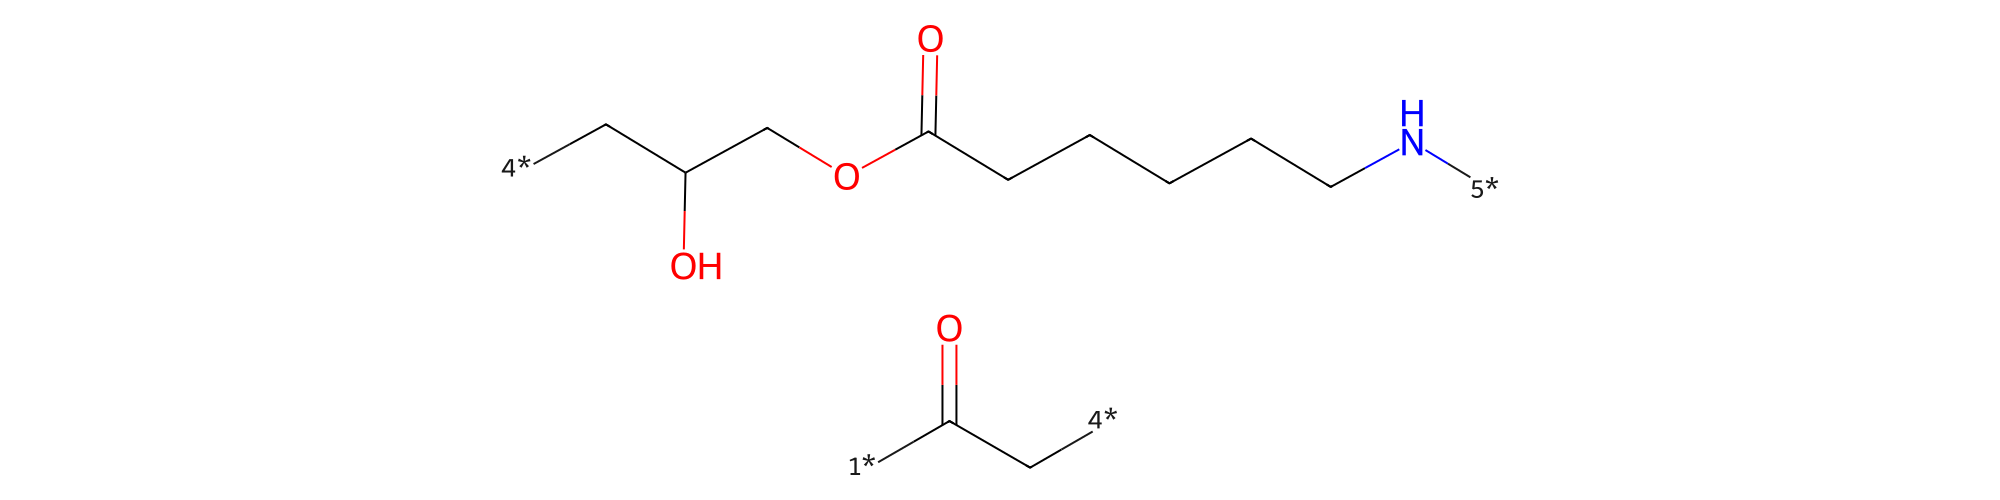

In [10]:
show_mol(rw_mol)

In [11]:
print("smarts_part >>", smarts_part)

smarts_part >> [4*]-[*:1].[5*]-[*:2]>>[$([C&!D1&!$(C=*)]-&!@[#6]):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2] 


In [12]:
def find_bond_indicies(smarts_str: str):
    reactant_cont = smarts_str.split(">>")[0]
    parts = reactant_cont.split(".")
    assert len(parts) == 2, "Expected 2 parts in the reactant container"
    wildcard1= parts[0].split("-")[0]
    wildcard2= parts[1].split("-")[0]
    return wildcard1, wildcard2

In [13]:
find_bond_indicies(smarts_part)

('[4*]', '[5*]')

In [14]:
def form_extrabond(rwmol, smarts_part):
    part1, part2 = [], []
    for atom in rwmol.GetAtoms():
        smarts = atom.GetSmarts()
        if "*" in smarts:
            if len(part1) == 2:
                part2.append({atom.GetIdx(): smarts})
            else:
                part1.append({atom.GetIdx(): smarts})

    wildcard1, wildcard2 = find_bond_indicies(smarts_part)
    comp = [wildcard1, wildcard2]
    bond_index1, bond_index2 = -1, -1
    for part in part1:
        for idx, smarts in part.items():
            for wildcard in comp:
                if wildcard in smarts:
                    bond_index1 = idx
                    comp.remove(wildcard)
    for part in part2:
        for idx, smarts in part.items():
            for wildcard in comp:
                if wildcard in smarts:
                    bond_index2 = idx
    # print("wildcard 1 >>", wildcard1)
    # print("wildcard 2 >>", wildcard2)
    # print("part1 >>", part1)
    # print("part2 >>", part2)
    # print("bond_index1 >>", bond_index1)
    # print("bond_index2 >>", bond_index2)
    # print("wildcard1, wildcard2 >>", wildcard1, wildcard2)
    copy_mol = copy.deepcopy(rwmol)
    copy_mol.AddBond(bond_index1, bond_index2, Chem.BondType.SINGLE)
    for bond in copy_mol.GetBonds():
        # print("bond.GetIdx() >>", bond.GetIdx())
        if bond.GetBeginAtomIdx() in [bond_index1, bond_index2] and  bond.GetEndAtomIdx() in [bond_index1, bond_index2]:
                bond.SetProp("reaction_SMARTS", smarts_part)
    return copy_mol, (wildcard1, wildcard2), smarts_part 

In [15]:
mol, (wildcard1, wildcard2), smarts_part = form_extrabond(rw_mol, smarts_part)

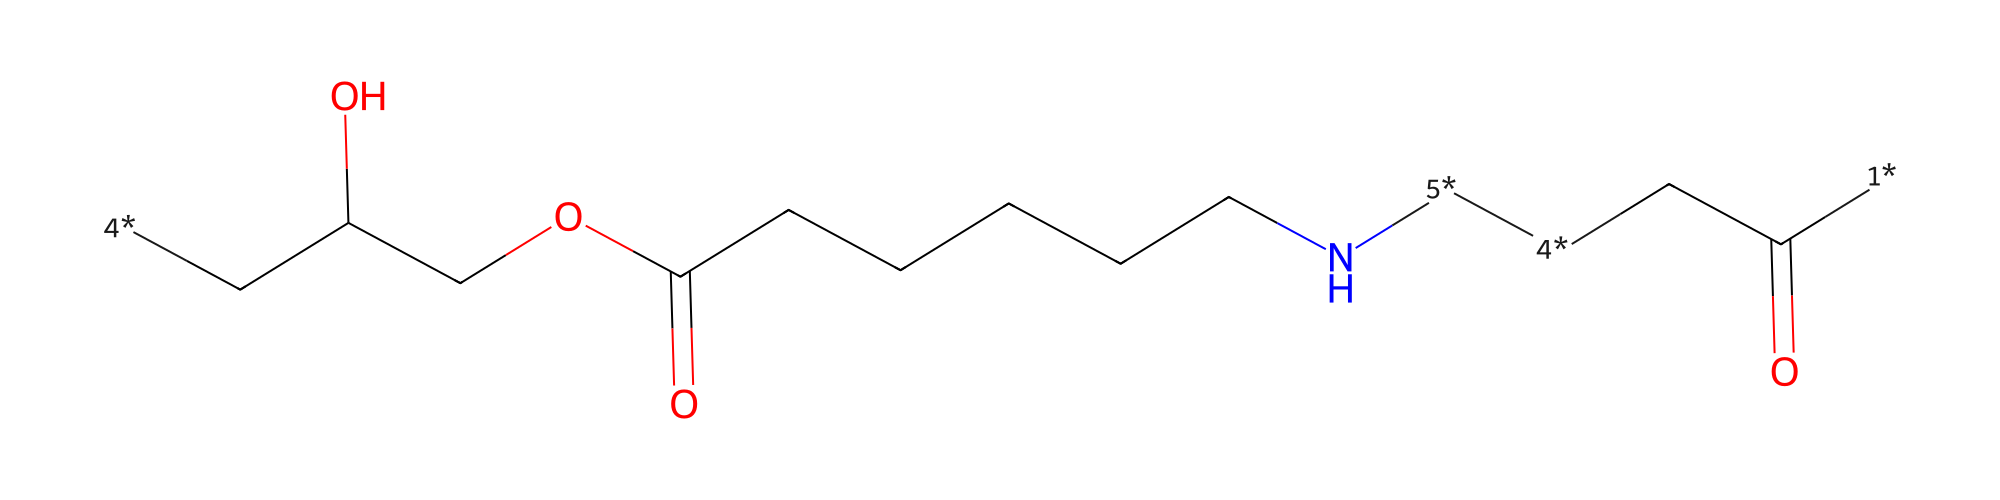

In [16]:
show_mol(mol)

In [17]:
def parse_weight(weight_part: str):
    weight_split = weight_part.split("|")
    prop_w1 = weight_split[1]
    prop_w2 = weight_split[2]
    rules = weight_split[3:]
    rules = rules[0].split("<")[1:]
    rule_weights = [] 
    for r in rules:
        atoms, weight1, weight2 = r.split(":")
        atoms = list(map(int, atoms.split("-")))
        # print("atoms >>", atoms)
        # print("weight1 >>", weight1)
        # print("weight2 >>", weight2)
        assert weight1 == weight2, "Expected weight1 and weight2 to be the same for current implementation"
        rule_weights.append((atoms, float(weight1)))
    return prop_w1, prop_w2, rule_weights

In [18]:
parse_weight(weight_part)

('0.5', '0.5', [([1, 3], 0.5), ([1, 4], 0.5), ([2, 3], 0.5), ([2, 4], 0.5)])

In [19]:
import json
def form_atom_weights(mol, weight_part: str):
    atom_w1, atom_w2, rule_weights = parse_weight(weight_part)
    atom_map = {}
    prop_map = {}
    counter = 1
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "*":
            atom_map[counter] = atom.GetSmarts()
            counter += 1
    for atom in atom_map.keys():
        content = {}
        for rule in rule_weights:
            atoms, weight = rule
            if atom in atoms:
                try:
                    alt_ind = [x for x in atoms if x != atom][0]
                    content[f"{atom_map[alt_ind]}"] = weight
                except Exception as e:
                    ...
                    # print("Error processing rule:", rule, "for atom:", atom, "Error:", e)
        prop_map[atom] = content
    # print("prop_map >>", prop_map) 
    # print("atom_map >>", atom_map)
    # print("atom_w1 >>", atom_w1)
    # print("atom_w2 >>", atom_w2)
    # print("rule_weights >>", rule_weights)
    counter = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "*":
            props = prop_map.get(counter+1, {})
            # print(f"props found for {counter + 1} >>", props)
            atom.SetProp("atomNote", json.dumps(props))
            counter += 1
    return mol 

In [20]:
new_mol = form_atom_weights(mol, weight_part)

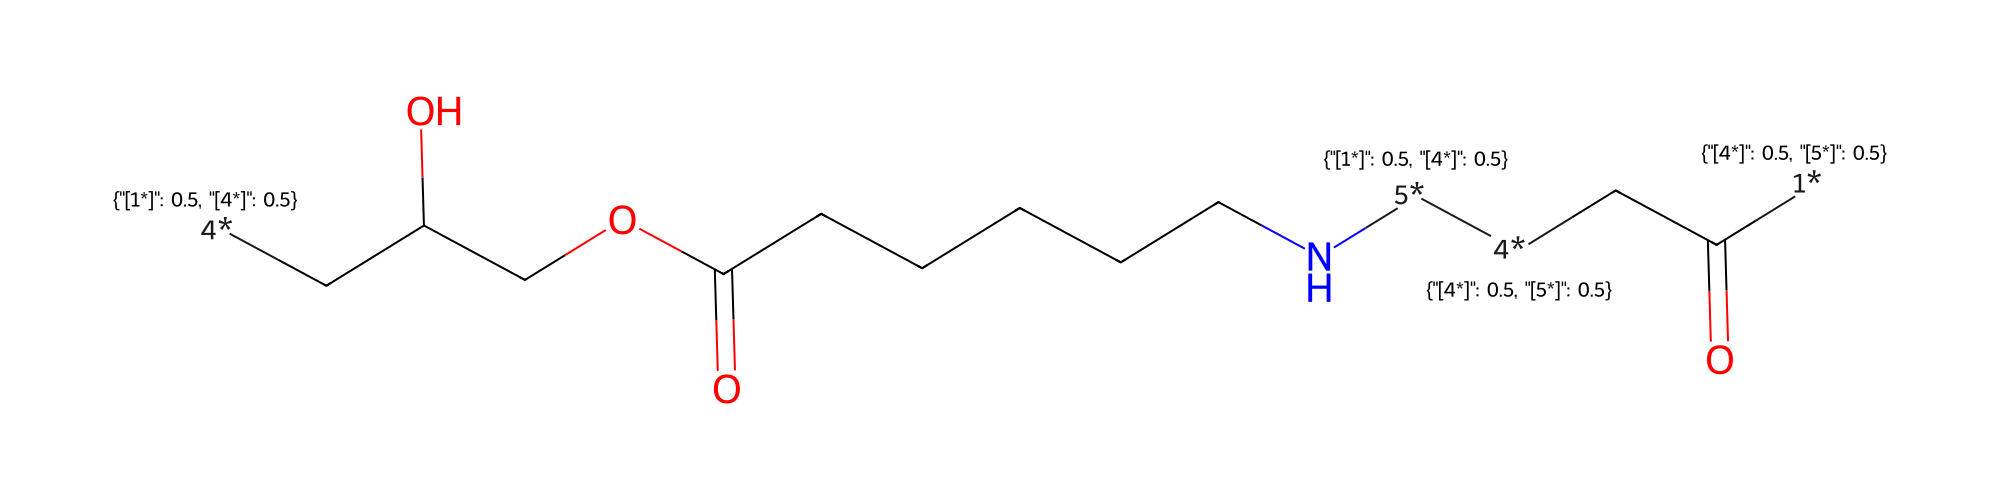

In [21]:
show_mol(new_mol)

In [22]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
import rdkit

In [24]:
doravirine = Chem.MolFromSmiles('Cn1c(n[nH]c1=O)Cn2ccc(c(c2=O)Oc3cc(cc(c3)Cl)C#N)C(F)(F)F')
rdDepictor.Compute2DCoords(doravirine)
rdDepictor.StraightenDepiction(doravirine)

In [26]:
from PIL import Image
from io import BytesIO
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)
def show_images(imgs,buffer=5):
    height = 0
    width = 0
    for img in imgs:
        height = max(height,img.height)
        width += img.width
    width += buffer*(len(imgs)-1)
    res = Image.new("RGBA",(width,height))
    x = 0
    for img in imgs:
        res.paste(img,(x,0))
        x += img.width + buffer
    return res

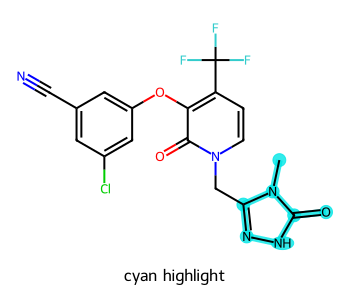

In [31]:
imgs = []
# d2d = Draw.MolDraw2DCairo(350,300)
# imgs.append(show_mol(d2d,doravirine,legend='default highlight', highlightAtoms=(0,1,2,3,4,5,6)))

d2d = Draw.MolDraw2DCairo(350,300)
dopts = d2d.drawOptions()
dopts.setHighlightColour((0,.9,.9,.8))
imgs.append(show_mol(d2d,doravirine,legend='cyan highlight', highlightAtoms=(0,1,2,3,4,5,6)))


show_images(imgs)

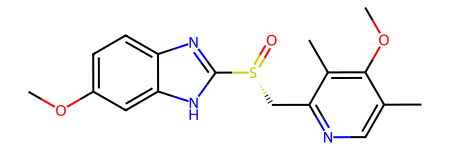

In [26]:
esomep = Chem.MolFromSmiles('COc1ccc2nc([nH]c2c1)[S@](=O)Cc1ncc(C)c(OC)c1C')
rdDepictor.Compute2DCoords(esomep)
esomep

In [27]:
from IPython.display import SVG

atom highlights >> defaultdict(<class 'list'>, {2: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 3: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 4: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 5: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 9: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 10: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 14: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 15: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 16: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 17: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 19: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 22: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 6: 

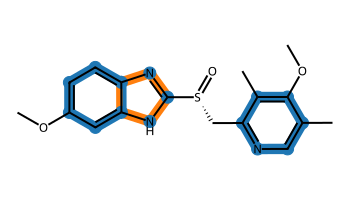

In [28]:
from collections import defaultdict
from matplotlib import colors

matches1 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaaa1'))
color1 = colors.to_rgb('C0')
matches2 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaa1'))
color2 = colors.to_rgb('C1')

rad = 0.3
atomHighlights = defaultdict(list)
bondHighlights = defaultdict(list)
atomRads = {}

for (matches,color) in zip((matches1,matches2),(color1,color2)):
    for match in matches:
        for i,aid in enumerate(match):
            atomHighlights[aid].append(color1)
            atomRads[aid] = rad
            bnd = esomep.GetBondBetweenAtoms(aid,match[(i+1)%len(match)])
            bondHighlights[bnd.GetIdx()].append(color)
        
d2d = Draw.MolDraw2DSVG(350,200)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
# I think this looks better if we ensure that the atom highlights are always circles:
dopts.atomHighlightsAreCircles = True
d2d.DrawMoleculeWithHighlights(esomep,"",dict(atomHighlights),dict(bondHighlights),atomRads,{})
print("atom highlights >>", atomHighlights)
print("bond highlights >>", bondHighlights)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [34]:
from collections import defaultdict
from matplotlib import colors
import cairosvg
from io import BytesIO
import matplotlib.pyplot as plt

repr = '[1*]C(=O)C[4*].[4*]CC(O)COC(=O)CCCCCN[5*]|[4*]-[*:1].[5*]-[*:2]>>[$([C&!D1&!$(C=*)]-&!@[#6]):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5'

smiles_part, smarts_part, weight_part = parse_parts(repr)
rw_mol = Chem.RWMol(Chem.MolFromSmiles(smiles_part))
mol, (wildcard1, wildcard2), smarts_part = form_extrabond(rw_mol, smarts_part)
src_mol = form_atom_weights(mol, weight_part)

matches1 = src_mol.GetSubstructMatches(Chem.MolFromSmiles('[1*]C(=O)C[4*]'))
color1 = (0.0, 1.0, 0.0, 0.8) 
matches2 = src_mol.GetSubstructMatches(Chem.MolFromSmiles('[4*]CC(O)COC(=O)CCCCCN[5*]'))
color2 = (1.0, 1.0, 0.0, 0.8)

rad = 0.3
atomHighlights = defaultdict(list)
bondHighlights = defaultdict(list)
atomRads = {}

# for (matches,color) in zip((matches1,matches2),(color1,color2)):
#     for match in matches:
#         for i,aid in enumerate(match):
#             atomHighlights[aid].append(color)
#             atomRads[aid] = rad
#             bnd = mol.GetBondBetweenAtoms(aid,match[(i+1)%len(match)])
#             # print("aid >>", aid)
#             # print("next aid >>", match[(i+1)%len(match)])
#             # print("bnd >>", bnd)
#             if bnd is not None:
#                 bondHighlights[bnd.GetIdx()].append(color)
#             else:
#                 print("aid >>", aid)
#                 print("next aid >>", match[(i+1)%len(match)])
#                 print("bnd >>", bnd)

# print("matches1 >>", matches1)
# print("matches2 >>", matches2)

for atom in src_mol.GetAtoms():
    atom_idx = atom.GetIdx()
    if atom_idx in matches1[0]:
        atomHighlights[atom_idx].append(color1)
        atomRads[atom_idx] = rad
    if atom_idx in matches2[0]:
        atomHighlights[atom_idx].append(color2)
        atomRads[atom_idx] = rad

for bond in src_mol.GetBonds():
    begin_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    if (begin_idx in matches1[0]) and (end_idx in matches1[0]):
        bondHighlights[bond.GetIdx()].append(color1)
    if (begin_idx in matches2[0]) and (end_idx in matches2[0]):
        bondHighlights[bond.GetIdx()].append(color2)


img = Draw.MolToImage(src_mol, size=(700,400), 
                      highlightAtoms=[[0,1],[3,4]], 
                      highlightBonds=[0,2], 
                      highlightAtomColors=[(0,1,0,0.8),(0,1,0,0.8)], 
                      highlightBondColors=(1,1,0,0.8))


# img = Draw.MolToImage(src_mol, size=(700,400), 
#                       highlightAtoms=list(atomHighlights.keys()), 
#                       highlightBonds=list(bondHighlights.keys()), 
#                       highlightAtomColors=dict(atomHighlights), 
#                       highlightBondColors=dict(bondHighlights))
# d2d = Draw.MolDraw2DSVG(700,400)
# dopts = d2d.drawOptions()
# dopts.useBWAtomPalette()
# # I think this looks better if we ensure that the atom highlights are always circles:
# dopts.atomHighlightsAreCircles = True
# d2d.DrawMoleculeWithHighlights(src_mol,"",dict(atomHighlights),dict(bondHighlights),atomRads,{})

# d2d.FinishDrawing()

# # Convert SVG to PNG
# png_data = cairosvg.svg2png(bytestring=d2d.GetDrawingText().encode())

# Create matplotlib figure
# img = plt.imread(BytesIO(png_data))
# img = plt.imread(img)
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')
# SVG(d2d.GetDrawingText())

TypeError: No registered converter was able to produce a C++ rvalue of type int from this Python object of type list

In [49]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import json


def show_image(new_mol, wildcard1, wildcard2, smarts_part):
    # Draw molecule without notes
    img = Draw.MolToImage(new_mol, size=(3000, 800))


    # Create Matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.imshow(img)
    ax.axis('off')  # Hide axes

    # Add text box for long props (multiline supported)
    props_text = f"Reaction SMARTS Between {wildcard1} and {wildcard2}: \n\n{smarts_part}\n\n"
    props_text = props_text.replace('$', '\\$')


    ax.text(0.5, -0.1, props_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.show()
# Or save: plt.savefig('mol_with_legend.png', bbox_inches='tight')


In [42]:
def match_substructure(mol, substructure_smiles):
    substructure = Chem.MolFromSmiles(substructure_smiles)
    matches = mol.GetSubstructMatches(substructure)
    return matches

In [49]:
def show_master(repr: str):
    # try:
    smiles_part, smarts_part, weight_part = parse_parts(repr)
    rw_mol = Chem.RWMol(Chem.MolFromSmiles(smiles_part))
    mol, (wildcard1, wildcard2), smarts_part = form_extrabond(rw_mol, smarts_part)
    new_mol = form_atom_weights(mol, weight_part)
    matches1 = match_substructure(new_mol, "[4*]")
    print("matches1 >>", matches1)
    # show_image(new_mol, wildcard1, wildcard2, smarts_part)

    # except Exception as e:
        # print("Error parsing parts:", e)
        # return 

In [50]:
values = [
    "[1*]C(=O)C[4*].[4*]CC(O)COC(=O)CCCCCN[5*]|[4*]-[*:1].[5*]-[*:2]>>[$([C&!D1&!$(C=*)]-&!@[#6]):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5",
    # "[1*]C(=O)C[4*].[4*]CC(O)COC(=O)CCCCCN[5*]|[4*]-[*:1].[5*]-[*:2]>>[$([C&!D1&!$(C=*)]-&!@[#6]):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2]|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125",
    # "[1*]C(=O)C([3*])O.[4*]C(C)COCCCCCC(=O)N[5*]|[3*]-[*:1].[4*]-[*:2]>>[$([O&D2]-&!@[#0,#6,#1]):1]-&!@[$([C&!D1&!$(C=*)]-&!@[#6]):2]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5",
    # "[1*]C(=O)C([3*])O.[4*]C(C)COCCCCCC(=O)N[5*]|[3*]-[*:1].[4*]-[*:2]>>[$([O&D2]-&!@[#0,#6,#1]):1]-&!@[$([C&!D1&!$(C=*)]-&!@[#6]):2]|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125",
    # "[1*]C([1*])=O.[3*]OCCCNCN[5*]|[1*]-[*:1].[5*]-[*:2]>>[$([C&D3]([#0,#6,#7,#8])=O):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5",
    # "[1*]C([1*])=O.[3*]OCCCNCN[5*]|[1*]-[*:1].[5*]-[*:2]>>[$([C&D3]([#0,#6,#7,#8])=O):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2]|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125",
    # "[1*]C(=O)C([4*])C.[4*]CC(=O)NCNCC(O)N[5*]|[4*]-[*:1].[5*]-[*:2]>>[$([C&!D1&!$(C=*)]-&!@[#6]):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5",
    # "[1*]C(=O)C([4*])C.[4*]CC(=O)NCNCC(O)N[5*]|[4*]-[*:1].[5*]-[*:2]>>[$([C&!D1&!$(C=*)]-&!@[#6]):1]-&!@[$([N&!D1&!$(N=*)&!$(N-[!#6&!#16&!#0&!#1])&!$([N&R]@[C&R]=O)]):2]|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125",
    # "[1*]C(=O)C[4*].[3*]OC(O)CNCNCC([4*])C|[1*]-[*:1].[3*]-[*:2]>>[$([C&D3]([#0,#6,#7,#8])=O):1]-&!@[$([O&D2]-&!@[#0,#6,#1]):2]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5",
    # "[1*]C(=O)C[4*].[3*]OC(O)CNCNCC([4*])C|[1*]-[*:1].[3*]-[*:2]>>[$([C&D3]([#0,#6,#7,#8])=O):1]-&!@[$([O&D2]-&!@[#0,#6,#1]):2]|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125",
]

In [51]:
for v in values:
    show_master(v)

matches1 >> ((4,), (5,))
